# How to deal with poisoned a dataset in the scope of a hackathon?

This method has been applied after regular approaches (EDA, feature engineering, modeling,...) that don't work with this dataset where signal has been erased.

1. Hypothesis:
Some cities should be more easy to model than others and drive further improvement to the way of the best possible solution.  

2. Demonstration method:
For every cities, we use a fast aml (mljar) framework to build a basic multi model training where we check msle metric on train dataset and look at predictions of this model using test dataset.we analyze results to find potential alignment between training score and predictions for each city and betwween cities. For this baseline approach, we use same modeling algorithms (Baseline-LR, Decision Tree, Random Forest, Xgboost and Neural Network).


In [1]:
!pip install mljar-supervised

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.5/90.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 4.0 MB/s eta 0:00:00
  Created wheel for mljar-supervised: filename=mljar_supervised-0.11.5-py3-none-any.whl size=147063 sha256=17f62be5ee186b48b48479a777c8027c12eeac4bedbe823d41a39013196035aa
  Stored in directory: /root/.cache/pip/wheels/d2/ad/3b/33f96fe146c1d7b0aaa94dc3f20be2b113b7e08e7355c3cd4a
Successfully built mljar-supervised
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.8.4
    Uninstalling graphviz-0.8.4:
      Successfully uninstalled graphviz-0.8.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mxnet 1.9.1 requires graphviz<0.9.0,>=0.8.1, but you have graphv

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from supervised.automl import AutoML
from sklearn.metrics import mean_squared_log_error
from tqdm import tqdm
from collections import Counter

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mh-aqi/submission.csv
/kaggle/input/mh-aqi/train.csv
/kaggle/input/mh-aqi/test.csv


In [3]:
train = pd.read_csv("/kaggle/input/mh-aqi/train.csv", parse_dates = ["Datetime"])
test = pd.read_csv("/kaggle/input/mh-aqi/test.csv", parse_dates = ["Datetime"])
sample_submission = pd.read_csv("/kaggle/input/mh-aqi/submission.csv")
test['AQI_Bucket'] = -1

In [4]:
train['index'] = list(range(0,train.shape[0]))
test['index'] = list(range(train.shape[0],train.shape[0]+test.shape[0]))

In [5]:
df = train.append(test)

In [6]:
city = []
bestscores = []

for i in df['City'].unique():
    temp = df[df['City'] == i]
    new_test = temp[temp['AQI_Bucket']==-1]
    new_train = temp[temp['AQI_Bucket']!=-1]
    y_train = new_train['AQI_Bucket']
    del new_train['AQI_Bucket']
    X_train = new_train
    automl = AutoML(
        mode="Explain",#"Compete",#"Perform","Explain"
        eval_metric = 'logloss',
        features_selection=False # switch off feature selection
    )
    automl.fit(X_train, y_train)
    pred = automl.predict(X_train)
    msle = np.sqrt(mean_squared_log_error(pred, y_train))
    print(i, "MSLE on train data:", msle)
    city.append(i)
    bestscores.append(msle)
    pred = automl.predict(new_test)
    values, counts = np.unique(pred, return_counts=True)
    print('Predictions on',i,'test data are:')
    for j in range(0,len(values)):
        print(counts[j],'of',values[j])


Linear algorithm was disabled.
AutoML directory: AutoML_1
The task is multiclass_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline logloss 1.945763 trained in 0.75 seconds
2_DecisionTree logloss 1.967956 trained in 27.67 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost logloss 1.946082 trained in 26.19 seconds
4_Default_NeuralNetwork logloss 1.946878 trained in 10.38 seconds
5_Default_RandomForest logloss 1.945778 trained in 24.8 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 1.945396 trained in 0.67 seconds
AutoML fit time: 102.39 seconds
AutoML best model: Ensemble
Jaipur MSLE on train data: 0.7499081964387017
Predictions on Jaipur test data are:
164 

3. Analysis of results:

Finding #1 : Predictions distributions for all cities are not aligned with full train dataset distribution, model don't learn for most of the cities.


In [7]:
pd.value_counts(train['AQI_Bucket'])

5    71123
4    71024
3    71017
0    70975
6    70602
2    70447
1    70324
Name: AQI_Bucket, dtype: int64

Finding #2 : Best cities models in terms of MSLE (Patna and Shillong) predict single target class (2 or 3).

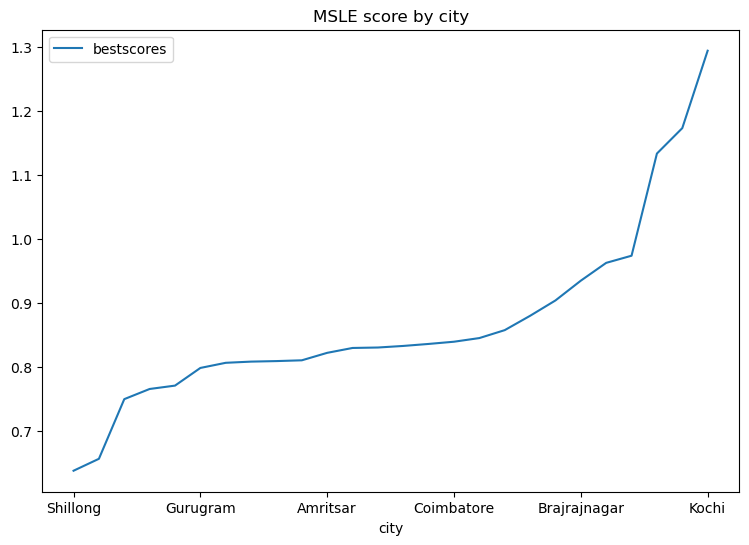

In [8]:
results = pd.DataFrame()
results['city'] = city
results['bestscores'] = bestscores
results = results.sort_values('bestscores')
results.set_index("city", inplace = True)
results.plot(figsize=(9,6),title='MSLE score by city');

# Can we confirm finding #2?

Yes, we can mesure metric on the train dataset per single class and see that single target 2 is an optimal solution if we submit integer as target.

In [9]:
best = 1.
target = -1
for i in train['AQI_Bucket'].unique():
    train['target'] = i
    target = train['target']
    real = train['AQI_Bucket']
    msle = np.sqrt(mean_squared_log_error(target, real))
    print('Uniform target:',i,'deliver MSLE:',msle)
    if msle <= best:
        best = msle
        target = i
    
print('Best value:' ,target, 'With MSLE:',best)

Uniform target: 5 deliver MSLE: 0.8550761211449995
Uniform target: 1 deliver MSLE: 0.8235565493448045
Uniform target: 3 deliver MSLE: 0.6561865205926675
Uniform target: 4 deliver MSLE: 0.7451945463945265
Uniform target: 6 deliver MSLE: 0.9652426737689271
Uniform target: 0 deliver MSLE: 1.3736142318592706
Uniform target: 2 deliver MSLE: 0.6455430428037874
Best value: 2 With MSLE: 0.6455430428037874


# We can now simply generalize the approach looking for the best float target value.

To optimize, i build here a local solver.


In [10]:
best = 1.
target = -1
for i in tqdm(range(200,300)):
    train['target'] = i/100
    targets = train['target']
    real = train['AQI_Bucket'].astype(float)
    msle = np.sqrt(mean_squared_log_error(targets, real))
    #print('Uniform target:',i/100,'deliver MSLE:',msle)
    if msle <= best:
        best = msle
        target = i/100
    
print('Best value:' ,target, 'With MSLE:',best)

100%|██████████| 100/100 [00:02<00:00, 41.12it/s]

Best value: 2.38 With MSLE: 0.63433699932796


In [11]:
best = 1.
target = -1
for i in tqdm(range(238000,239000)):
    train['target'] = i/100000
    targets = train['target']
    real = train['AQI_Bucket'].astype(float)
    msle = np.sqrt(mean_squared_log_error(targets, real))
    #print('Uniform target:',i/100000,'deliver MSLE:',msle)
    if msle <= best:
        best = msle
        target = i/100000
    
print('Best value:' ,target, 'With MSLE:',best)

100%|██████████| 1000/1000 [00:24<00:00, 41.03it/s]

Best value: 2.38168 With MSLE: 0.6343368043666137


In [12]:
sample_submission['AQI_Bucket'] = target
sample_submission.head()

,AQI_Bucket
0,2.38168
1,2.38168
2,2.38168
3,2.38168
4,2.38168


In [13]:
sample_submission.to_csv('Sol_AQI.csv', index= False)